In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import ternary
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

os.environ["CUDA_VISIBLE_DEVICES"] = '012'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')

2024-12-26 09:15:44.207494: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-12-26 09:15:47.470537: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-26 09:15:47.470595: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ubuntu
2024-12-26 09:15:47.470601: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ubuntu
2024-12-26 09:15:47.470853: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.182.3
2024-12-26 09:15:47.470883: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.182.3
2024-12-26 09:15:47.470887: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.182.3


In [12]:
from sklearn.mixture import GaussianMixture

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
def build_model(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(32, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [4]:
def build_model_clustering(input_dim):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

Repertoire 0
Train on 240000 samples, validate on 60000 samples
Epoch 1/50
240000/240000 [==============================] - 1s 6us/sample - loss: 1.0994 - accuracy: 0.3346 - val_loss: 1.0987 - val_accuracy: 0.3332
Epoch 2/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0987 - accuracy: 0.3341 - val_loss: 1.0987 - val_accuracy: 0.3345
Epoch 3/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0987 - accuracy: 0.3339 - val_loss: 1.0987 - val_accuracy: 0.3322
Epoch 4/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0987 - accuracy: 0.3344 - val_loss: 1.0988 - val_accuracy: 0.3324
Epoch 5/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0987 - accuracy: 0.3346 - val_loss: 1.0990 - val_accuracy: 0.3328
Epoch 6/50
240000/240000 [==============================] - 1s 4us/sample - loss: 1.0987 - accuracy: 0.3328 - val_loss: 1.0987 - val_accuracy: 0.3338
Epoch 7/50
240000/240000 [==========

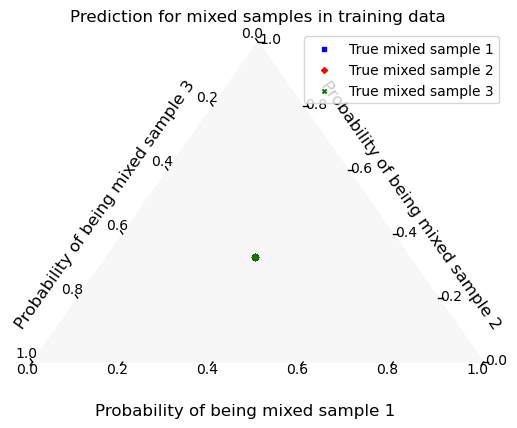

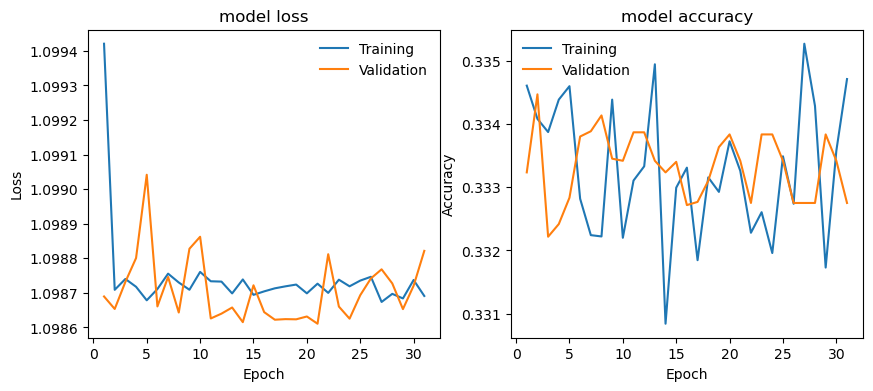

Train on 3000 samples
Epoch 1/10
3000/3000 [==============================] - 0s 126us/sample - loss: 0.3164 - accuracy: 0.9343
Epoch 2/10
3000/3000 [==============================] - 0s 53us/sample - loss: 0.2586 - accuracy: 0.9427
Epoch 3/10
3000/3000 [==============================] - 0s 50us/sample - loss: 0.2615 - accuracy: 0.9427
Epoch 4/10
3000/3000 [==============================] - 0s 56us/sample - loss: 0.2588 - accuracy: 0.9427
Epoch 5/10
3000/3000 [==============================] - 0s 59us/sample - loss: 0.2634 - accuracy: 0.9427
Epoch 6/10
3000/3000 [==============================] - 0s 58us/sample - loss: 0.2622 - accuracy: 0.9427
Epoch 7/10
3000/3000 [==============================] - 0s 54us/sample - loss: 0.2581 - accuracy: 0.9427
Epoch 8/10
3000/3000 [==============================] - 0s 52us/sample - loss: 0.2578 - accuracy: 0.9427
Epoch 9/10
3000/3000 [==============================] - 0s 53us/sample - loss: 0.2589 - accuracy: 0.9427
Epoch 10/10
3000/3000 [=========

ValueError: not enough values to unpack (expected 2, got 0)

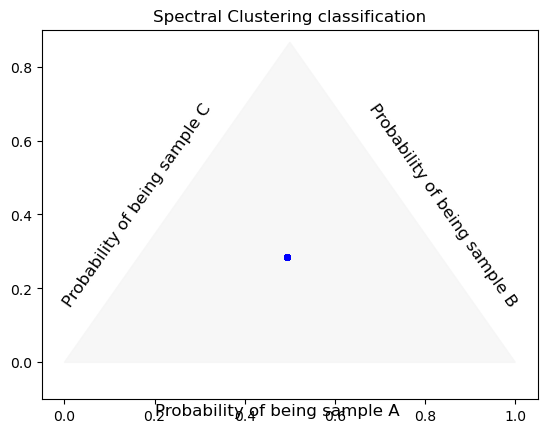

In [17]:
ml_total_accuracy = []
spec_total_accuracy = []
max_total_accuracy = []
for i in range(3):
    print(f"Repertoire {i}")
    mean_1 = [0, 0, 0, 0, 0]
    cov_1 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

    mean_2 = [1, 1, 1, 1, 1]
    cov_2 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]

    mean_3 = [-1, -1, -1, -1, -1]
    cov_3 = [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1,0], [0, 0, 0, 0, 1]]


    x_1 = np.random.multivariate_normal(mean_1, cov_1, size=1000000)
    y_1 = np.random.multivariate_normal(mean_1, cov_1, size=100000)

    x_2 = np.random.multivariate_normal(mean_2, cov_2, size=1000000)
    y_2 = np.random.multivariate_normal(mean_2, cov_2, size=100000)

    x_3 = np.random.multivariate_normal(mean_3, cov_3, size=1000000)
    y_3 = np.random.multivariate_normal(mean_3, cov_3, size=100000)
    
    x_kmeans_1 =  np.random.multivariate_normal(mean_1, cov_1, size=1000)
    x_kmeans_2 =  np.random.multivariate_normal(mean_2, cov_2, size=1000)
    x_kmeans_3 =  np.random.multivariate_normal(mean_3, cov_3, size=1000)
    rng = np.random.default_rng()
    x_train_kmeans = np.concatenate((x_kmeans_1, x_kmeans_2, x_kmeans_3))
    indices_kmeans = rng.permutation(np.shape(x_train_kmeans)[0])
    x_train_kmeans = x_train_kmeans[indices_kmeans]
    
    n_samples = 3
    n_1_1 = 60000 #Number of signal samples in dominant class
    n_1_2 = 20000
    n_1_3 = 20000

    n_2_1 = 60000
    n_2_2 = 20000
    n_2_3 = 20000

    n_3_1 = 60000
    n_3_2 = 20000
    n_3_3 = 20000

    sample_1_1_train = x_1[0:n_1_1]
    #Using one-hot encoding here
    true_label_sample_1_1_train = np.tile(np.array([1., 0., 0.]), 
                                          np.shape(sample_1_1_train)[0]).reshape(np.shape(sample_1_1_train)[0],n_samples)

    sample_1_2_train = x_2[0:n_1_2]
    true_label_sample_1_2_train = np.tile(np.array([0., 1., 0.]), 
                                          np.shape(sample_1_2_train)[0]).reshape(np.shape(sample_1_2_train)[0],n_samples)
    sample_1_3_train = x_3[0:n_1_3]
    true_label_sample_1_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_1_3_train)[0]).reshape(np.shape(sample_1_3_train)[0],n_samples)

    sample_2_1_train = x_1[n_1_1:n_1_1+n_2_1]
    #Using one-hot encoding here
    true_label_sample_2_1_train = np.tile(np.array([1., 0., 0.]), 
                                          np.shape(sample_2_1_train)[0]).reshape(np.shape(sample_2_1_train)[0],n_samples)

    sample_2_2_train = x_2[n_1_2:n_1_2 + n_2_2]
    true_label_sample_2_2_train = np.tile(np.array([0., 1., 0.]), 
                                          np.shape(sample_2_2_train)[0]).reshape(np.shape(sample_2_2_train)[0],n_samples)
    sample_2_3_train = x_3[n_1_3:n_1_3+n_2_3]
    true_label_sample_2_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_2_3_train)[0]).reshape(np.shape(sample_2_3_train)[0],n_samples)

    sample_3_1_train = x_1[n_1_1+n_2_1:n_1_1+n_2_1+n_3_1]
    #Using one-hot encoding here
    true_label_sample_3_1_train = np.tile(np.array([1., 0., 0.]), 
                                          np.shape(sample_3_1_train)[0]).reshape(np.shape(sample_3_1_train)[0],n_samples)

    sample_3_2_train = x_2[n_1_2+n_2_2:n_1_2+n_2_2+n_3_2]
    true_label_sample_3_2_train = np.tile(np.array([0., 1., 0.]), 
                                          np.shape(sample_3_2_train)[0]).reshape(np.shape(sample_3_2_train)[0],n_samples)
    sample_3_3_train = x_3[n_1_3+n_2_3:n_1_3+n_2_3+n_3_3]
    true_label_sample_3_3_train = np.tile(np.array([0., 0., 1.]), 
                                          np.shape(sample_3_3_train)[0]).reshape(np.shape(sample_3_3_train)[0],n_samples)
    
    x_test = np.concatenate((y_1, y_2, y_3))
    y_test_1 = np.tile(np.array([1., 0., 0.]), 
                np.shape(y_1)[0]).reshape(np.shape(y_1)[0],n_samples)
    y_test_2 = np.tile(np.array([0., 1., 0.]), 
                np.shape(y_2)[0]).reshape(np.shape(y_2)[0],n_samples)
    y_test_3 = np.tile(np.array([0., 0., 1.]), 
                np.shape(y_3)[0]).reshape(np.shape(y_3)[0],n_samples)
    y_test = np.concatenate((y_test_1, y_test_2, y_test_3))
    indices_test = rng.permutation(np.shape(x_test)[0])
    x_test = x_test[indices_test]
    y_test = y_test[indices_test]
    
    rng = np.random.default_rng()
    x_train_1 = np.concatenate((sample_1_1_train, sample_1_2_train, sample_1_3_train))
    y_train_1 = np.tile(np.array([1., 0., 0.]), 
                np.shape(x_train_1)[0]).reshape(np.shape(x_train_1)[0],n_samples)
    true_label_1 = np.concatenate((true_label_sample_1_1_train, true_label_sample_1_2_train, 
                                   true_label_sample_1_3_train))
    indices_1 = rng.permutation(np.shape(x_train_1)[0])

    x_shuffle_1 = x_train_1[indices_1]
    y_shuffle_1 = y_train_1[indices_1]
    true_label_shuffle_1 = true_label_1[indices_1]

    x_train_2 = np.concatenate((sample_2_1_train, sample_2_2_train, sample_2_3_train))
    y_train_2 = np.tile(np.array([0., 1., 0.]), 
                np.shape(x_train_2)[0]).reshape(np.shape(x_train_2)[0],n_samples)
    true_label_2 = np.concatenate((true_label_sample_2_1_train, true_label_sample_2_2_train, 
                                   true_label_sample_2_3_train))
    indices_2 = rng.permutation(np.shape(x_train_2)[0])

    x_shuffle_2 = x_train_2[indices_2]
    y_shuffle_2 = y_train_2[indices_2]
    true_label_shuffle_2 = true_label_2[indices_2]

    x_train_3 = np.concatenate((sample_3_1_train, sample_3_2_train, sample_3_3_train))
    y_train_3 = np.tile(np.array([0., 0., 1.]), 
                np.shape(x_train_3)[0]).reshape(np.shape(x_train_3)[0],n_samples)
    true_label_3 = np.concatenate((true_label_sample_3_1_train, true_label_sample_3_2_train, 
                                   true_label_sample_3_3_train))
    indices_3 = rng.permutation(np.shape(x_train_3)[0])

    x_shuffle_3 = x_train_3[indices_3]
    y_shuffle_3 = y_train_3[indices_3]
    true_label_shuffle_3 = true_label_3[indices_3]

    x_train = np.concatenate((x_shuffle_1, x_shuffle_2, x_shuffle_3))
    y_train = np.concatenate((y_shuffle_1, y_shuffle_2, y_shuffle_3))
    true_label_train = np.concatenate((true_label_shuffle_1, true_label_shuffle_2, true_label_shuffle_3))

    #y_train = np.argmax(y_train, axis = 1)
    #true_label_train = np.argmax(true_label_train, axis = 1)

    indices_train = rng.permutation(np.shape(x_train)[0])

    x_train = x_train[indices_train]
    y_train = y_train[indices_train]
    true_label_train = true_label_train[indices_train]

    model = build_model(x_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10)
    y_train_1 = y_train
    for i in range(1):
        history = model.fit(x_train, y_train_1, validation_split = 0.2, epochs=50, batch_size=1024, verbose=1, 
                        callbacks=[
                                  early_stopping,
                                   ])
        predict = model.predict(x_train)

        predict_0 = predict[np.argmax(y_train_1, axis = 1) == 0]
        predict_1 = predict[np.argmax(y_train_1, axis = 1) == 1]
        predict_2 = predict[np.argmax(y_train_1, axis = 1) == 2]

        # Set Axis labels and Title
        scale = 1.0
        fontsize = 12
        offset = 0.1
        figure, tax = ternary.figure(scale=scale)

        tax.set_title("Prediction for mixed samples in training data", fontsize=fontsize)
        tax.left_axis_label("Probability of being mixed sample 3", fontsize=fontsize, offset=offset)
        tax.right_axis_label("Probability of being mixed sample 2", fontsize=fontsize, offset=offset)
        tax.bottom_axis_label("Probability of being mixed sample 1", fontsize=fontsize, offset=offset)
        tax.scatter(predict_0, color = 'blue', marker = 's', s = 9, label="True mixed sample 1")
        tax.scatter(predict_1, color = 'red', marker = 'D', s = 9, label="True mixed sample 2")
        tax.scatter(predict_2, color = 'green', marker = 'x', s = 9, label="True mixed sample 3")

        # Set ticks
        tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

        # Background color
        tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

        # Remove default Matplotlib Axes
        tax.clear_matplotlib_ticks()
        tax.get_axes().axis('off')
        tax.legend()
        ternary.plt.show()
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        x = range(1, len(history.history['loss']) + 1)

        ax[0].plot(x, history.history['loss'], label='Training')
        ax[0].plot(x, history.history['val_loss'], label='Validation')

        ax[0].legend(frameon=False)
        ax[0].set_title(f'model loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')

        ax[1].plot(x, history.history['accuracy'], label='Training')
        ax[1].plot(x, history.history['val_accuracy'], label='Validation')

        ax[1].legend(frameon=False)
        ax[1].set_title(f'model accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        plt.show()
        predict[np.argmax(predict, axis = 1) == 0] = [1., 0., 0.]
        predict[np.argmax(predict, axis = 1) == 1] = [0., 1., 0.]
        predict[np.argmax(predict, axis = 1) == 2] = [0., 0., 1.]
        y_train_1 = predict
    x_train_post_model = model.predict(x_train_kmeans)
    spec_model = SpectralClustering(n_clusters=3, assign_labels = 'discretize')
    spec_results = spec_model.fit_predict(x_train_post_model)
    
    model_clustering =  build_model_clustering(x_train_post_model.shape[1])
    num_classes = 3
    one_hot_spec_results = np.eye(num_classes)[spec_results]
    history_2 = model_clustering.fit(x_train_post_model, one_hot_spec_results, epochs = 10)
    
    x_predict_pre_kmeans = model.predict(x_test[0:10000])
    x_predict_post_spec = spec_model.fit_predict(x_predict_pre_kmeans)
    predicted_labels = np.argmax(y_test[0:10000], axis = 1)
    print(predicted_labels[0:20])
    print(x_predict_post_spec[0:20])
    conf_matrix_spec = confusion_matrix(predicted_labels, x_predict_post_spec, labels = [0, 1, 2])
    print(conf_matrix_spec)
    # Step 2: Use Hungarian algorithm for optimal label assignment
    row_ind_spec, col_ind_spec = linear_sum_assignment(-conf_matrix_spec)  # Maximize matches
    # Step 3: Map predicted labels to desired labels
    label_mapping_spec = {row_spec: col_spec for col_spec, row_spec in zip(row_ind_spec, col_ind_spec)}
    print(label_mapping_spec)
   
    final_labels_spec = np.array([label_mapping_spec[label_spec] for label_spec in x_predict_post_spec])
    print(final_labels_spec[0:20])
    
    accuracy_spec = np.mean(final_labels_spec == np.argmax(y_test[0:10000], axis = 1))
    print(np.argmax(y_test[0:10000], axis = 1)[0:20])
    print(f"Spectral Clustering accuracy on pure data, {accuracy_spec*100:.2f}%")
    spec_total_accuracy.append(accuracy_spec)
    
    x_predict_post_ml = np.argmax(model_clustering.predict(x_predict_pre_kmeans), axis = 1)
    #Rematching of labels
    print(x_predict_post_ml[0:20])
    conf_matrix_ml = confusion_matrix(predicted_labels, x_predict_post_ml, labels = [0, 1, 2])
    print(conf_matrix_ml)
    # Step 2: Use Hungarian algorithm for optimal label assignment
    row_ind_ml, col_ind_ml = linear_sum_assignment(-conf_matrix_ml)  # Maximize matches

    # Step 3: Map predicted labels to desired labels
    label_mapping_ml = {row_ml: col_ml for col_ml, row_ml in zip(row_ind_ml, col_ind_ml)}
    print(label_mapping_ml)
    
    # Apply mapping to reorder labels
    final_labels_ml = np.array([label_mapping_ml[label_ml] for label_ml in x_predict_post_ml])
    print(final_labels_ml[0:20])
    print(predicted_labels[0:20])
    accuracy_ml = np.mean(final_labels_ml == np.argmax(y_test[0:10000], axis = 1))
    
    scale = 1.0
    fontsize = 12
    offset = 0.1
    figure, tax = ternary.figure(scale=scale)

    predict_kmeans_0 = x_predict_pre_kmeans[final_labels_ml == 0]
    predict_kmeans_1 = x_predict_pre_kmeans[final_labels_ml == 1]
    predict_kmeans_2 = x_predict_pre_kmeans[final_labels_ml == 2]
    tax.set_title("Spectral Clustering classification", fontsize=fontsize)
    tax.left_axis_label("Probability of being sample C", fontsize=fontsize, offset=offset)
    tax.right_axis_label("Probability of being sample B", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("Probability of being sample A", fontsize=fontsize, offset=offset)
    tax.scatter(predict_kmeans_0, color = 'blue', marker = 's', s = 9, label="ML prediction of sample A")
    tax.scatter(predict_kmeans_1, color = 'red', marker = 'D', s = 9, label="ML prediction of sample B")
    tax.scatter(predict_kmeans_2, color = 'green', marker = 'x', s = 9, label="ML prediction of sample C")
    # Set ticks
    tax.ticks(axis='lbr', multiple=0.2, linewidth=1, tick_formats="%.1f")

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the default, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.legend(loc = 'upper right')
    ternary.plt.show()

    print(f"ML accuracy on pure data, {accuracy_ml*100:.2f}%")
    ml_total_accuracy.append(accuracy_ml)
    
    loss, accuracy = model.evaluate(x_test[0:10000], y_test[0:10000], verbose=0)
    print(f"One-vs-All Test Accuracy on Pure Data: {accuracy * 100:.2f}%")
    max_total_accuracy.append(accuracy)
    
    



In [14]:
ml_total_accuracy = np.array(ml_total_accuracy)
spec_total_accuracy = np.array(spec_total_accuracy)
max_total_accuracy = np.array(max_total_accuracy)

In [38]:
print(spec_total_accuracy)

[0.7814 0.7791 0.7918 0.7871 0.7827 0.7967 0.7812 0.7895 0.7871 0.7773]


In [39]:
print(ml_total_accuracy)

[0.7546 0.7778 0.7864 0.7875 0.779  0.7964 0.7852 0.7923 0.7871 0.7749]


In [40]:
#First try, dominant case#
print(np.mean(ml_total_accuracy), np.std(ml_total_accuracy))
print(np.mean(spec_total_accuracy), np.std(spec_total_accuracy))
print(np.mean(max_total_accuracy), np.std(max_total_accuracy))

0.7821199999999999 0.011076894871758945
0.78539 0.005809208207664783
0.8137 0.0041684494


In [7]:
#Second run, ambigous first cases 
print(np.mean(ml_total_accuracy), np.std(ml_total_accuracy))
print(np.mean(spec_total_accuracy), np.std(spec_total_accuracy))
print(np.mean(max_total_accuracy), np.std(max_total_accuracy))

0.77127 0.028922104003685487
0.7871600000000001 0.00852856377123369
0.56396 0.062496863


In [10]:
#Third run, must fail cases 
print(np.mean(ml_total_accuracy), np.std(ml_total_accuracy))
print(np.mean(spec_total_accuracy), np.std(spec_total_accuracy))
print(np.mean(max_total_accuracy), np.std(max_total_accuracy))

0.60582 0.05522533476584818
0.63764 0.08744560823734945
0.54661 0.06402583


In [15]:
#Fourth run, GMM for clustering, ambiguous first case
print(np.mean(ml_total_accuracy), np.std(ml_total_accuracy))
print(np.mean(spec_total_accuracy), np.std(spec_total_accuracy))
print(np.mean(max_total_accuracy), np.std(max_total_accuracy))

0.75431 0.06958940221039404
0.75747 0.06813590903481072
0.53053 0.024067152


In [ ]:
print(np.mean(ml_total_accuracy), np.std(ml_total_accuracy))
print(np.mean(spec_total_accuracy), np.std(spec_total_accuracy))
print(np.mean(max_total_accuracy), np.std(max_total_accuracy))